In [1]:
import os
import PIL
import time
import glob
import imageio

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython.display import Image

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [5]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

### Wire up the generative and inference network with tf.keras.Sequential

In our VAE example, we use two small ConvNets for the generative and inference network. Since these neural nets are small, we use tf.keras.Sequential to simplify our code.

- Generative Network

This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. . Additionally, we use a unit Gaussian prior  for the latent variable.

- Inference Network

This defines an approximate posterior distribution , which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

- Reparameterization Trick

During optimization, we can sample from  by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

- Network architecture

For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

In [7]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape = (28, 28, 1)),
          tf.keras.layers.Conv2D(
              filters = 32, kernel_size = 3, strides = (2, 2), activation = 'relu'),
          tf.keras.layers.Conv2D(
              filters = 64, kernel_size = 3, strides = (2, 2), activation = 'relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape = (latent_dim,)),
          tf.keras.layers.Dense(units = 7*7*32, activation = tf.nn.relu),
          tf.keras.layers.Reshape(target_shape = (7, 7, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters = 64,
              kernel_size = 3,
              strides = (2, 2),
              padding = "SAME",
              activation = 'relu'),
          tf.keras.layers.Conv2DTranspose(
              filters = 32,
              kernel_size = 3,
              strides = (2, 2),
              padding = "SAME",
              activation = 'relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters = 1, kernel_size = 3, strides = (1, 1), padding = "SAME"),
        ]
    )

  @tf.function
  def sample(self, eps = None):
    if eps is None:
      eps = tf.random.normal(shape = (100, self.latent_dim))
    return self.decode(eps, apply_sigmoid = True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits = 2, axis = 1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape = mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid = False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

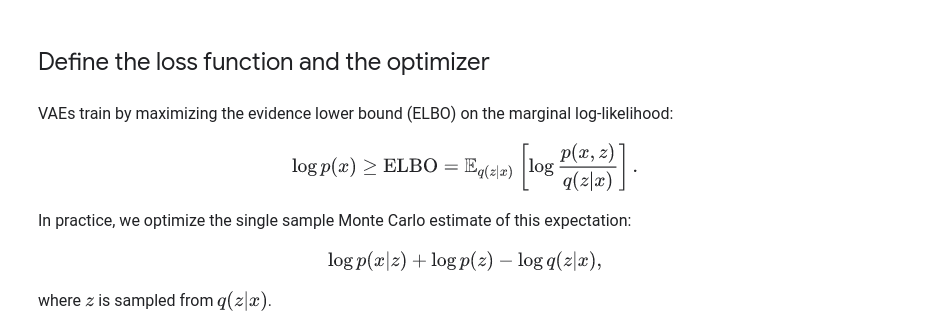

In [8]:
Image("VAE_loss.png")

In [9]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis = 1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis = raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits = x_logit, labels = x)
  logpx_z = -tf.reduce_sum(cross_ent, axis = [1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

### Training

In [10]:
epochs = 100
latent_dim = 50
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape = [num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [11]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize = (4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap = 'gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

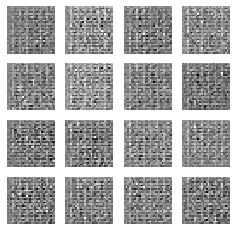

Epoch: 10, Test set ELBO: -93.0505599975586, time elapse for current epoch 3.019217014312744


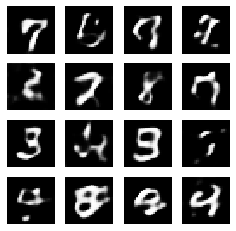

Epoch: 20, Test set ELBO: -86.28746032714844, time elapse for current epoch 2.9787166118621826


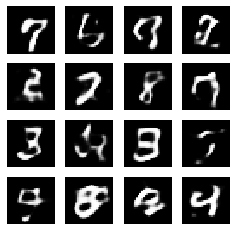

Epoch: 30, Test set ELBO: -83.61126708984375, time elapse for current epoch 3.0164811611175537


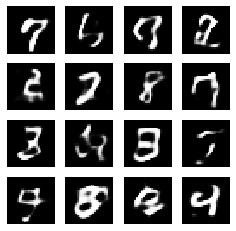

Epoch: 40, Test set ELBO: -81.96076965332031, time elapse for current epoch 2.974180221557617


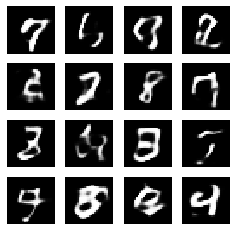

Epoch: 50, Test set ELBO: -80.93183898925781, time elapse for current epoch 3.026984691619873


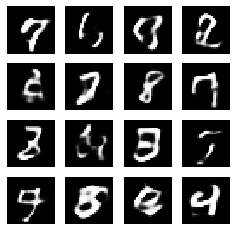

Epoch: 60, Test set ELBO: -80.1219711303711, time elapse for current epoch 3.3274600505828857


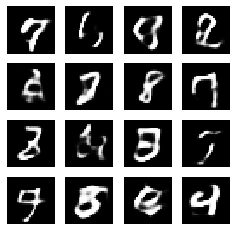

Epoch: 70, Test set ELBO: -79.49451446533203, time elapse for current epoch 3.107538938522339


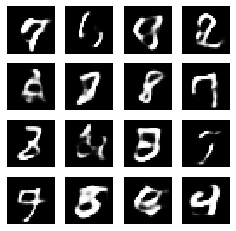

Epoch: 80, Test set ELBO: -78.92205810546875, time elapse for current epoch 3.126464605331421


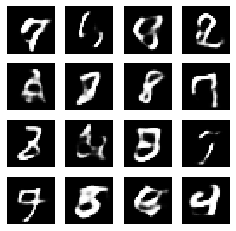

Epoch: 90, Test set ELBO: -78.41314697265625, time elapse for current epoch 3.0470266342163086


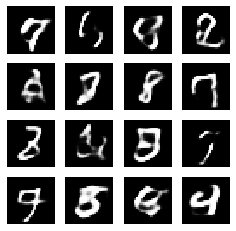

Epoch: 100, Test set ELBO: -78.16148376464844, time elapse for current epoch 3.3078742027282715


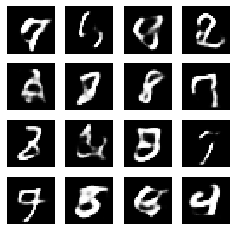

In [12]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 10 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)